In [26]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils, to_categorical
from skimage.transform import resize   # for resizing images
import os
import tqdm
from tqdm import tqdm,tqdm_pandas

In [11]:
os.chdir('D:/data_science/vedio/train')

In [4]:
cap = cv2.VideoCapture('Tom and jerry.mp4')
cap

<VideoCapture 0000029909A1F490>

In [5]:
count = 0
videoFile = "Tom and jerry.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


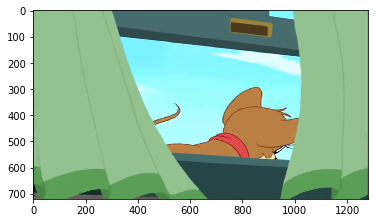

In [7]:
img = plt.imread('frame1.jpg')
plt.imshow(img)

In [10]:
mapping = pd.read_csv('mapping.csv')
mapping.head()
Y = mapping.Class
Y_cat = to_categorical(Y)

In [12]:
X = []
for id in mapping.Image_ID:
    im = cv2.imread(id)
    X.append(im)
X = np.array(X)    

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_last')
from keras import applications,models, losses,optimizers
from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape,InputLayer, regularizers,BatchNormalization
import numpy as np
import keras.backend as K
from keras.applications.vgg16 import VGG16

In [14]:
#preprocess for fit into VGG16 pretrained model model
image = []
for i in range(X.shape[0]):
    img = resize(X[i],preserve_range= True, output_shape=(224,224)).astype(int)
    image.append(img)
    
X = np.array(image)

from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X, mode='tf')
X.shape

C:\Users\Sourish\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(298, 224, 224, 3)

In [17]:
#Train-test split
from sklearn.cross_validation import train_test_split
train_X,valid_X,train_y,valid_y = train_test_split(X,Y_cat,test_size = 0.3, random_state = 20)

C:\Users\Sourish\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
base_model = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

In [18]:
train_X = base_model.predict(train_X)
valid_X = base_model.predict(valid_X)

In [19]:
#Building ANN with this feature
train_X = np.reshape(train_X,newshape=(train_X.shape[0],7*7*512)) 
valid_X = np.reshape(valid_X,newshape=(valid_X.shape[0],7*7*512)) 
train_X = train_X/train_X.max()
valid_X = valid_X/valid_X.max()

In [22]:
#keras ANN model for classification
mod = Sequential()
mod.add(InputLayer(input_shape=(7*7*512,)))
#mod.add(BatchNormalization(epsilon=1e-06, mode=0, momentum=0.9, weights=None))       
mod.add(Dense(units=1024,kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l1_l2(l1=0.01,l2=0.02),activation = 'sigmoid'))
mod.add(Dropout(rate=0.4))
#mod.add(Dense(units=256,kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l1_l2(l1=0.01,l2=0.02), activation = 'tanh'))
#mod.add(Dropout(rate=0.3))
mod.add(Dense(units=3,activation='softmax'))
optim = optimizers.Adam(lr=0.02)
mod.compile(optimizer=optim,metrics=['accuracy'],loss='categorical_crossentropy')
mod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3075      
Total params: 25,694,211
Trainable params: 25,694,211
Non-trainable params: 0
_________________________________________________________________


In [23]:
early_stop = EarlyStopping(patience=7, monitor='val_acc')
ckpt = ModelCheckpoint(monitor='val_loss', filepath='keras_best_mod',mode='auto',save_best_only=True)
mod.fit(train_X,train_y,batch_size=32,epochs=50,validation_data=[valid_X,valid_y],callbacks=[early_stop,ckpt],verbose=2)

Train on 208 samples, validate on 90 samples
Epoch 1/50
 - 3s - loss: 1628.8541 - acc: 0.3990 - val_loss: 1261.0896 - val_acc: 0.3778
Epoch 2/50
 - 0s - loss: 915.7067 - acc: 0.4087 - val_loss: 883.3264 - val_acc: 0.2222
Epoch 3/50
 - 0s - loss: 758.3875 - acc: 0.4183 - val_loss: 767.2870 - val_acc: 0.3778
Epoch 4/50
 - 0s - loss: 696.6677 - acc: 0.3750 - val_loss: 643.4305 - val_acc: 0.3889
Epoch 5/50
 - 0s - loss: 647.2870 - acc: 0.3510 - val_loss: 612.3473 - val_acc: 0.3778
Epoch 6/50
 - 0s - loss: 615.1219 - acc: 0.3894 - val_loss: 729.0930 - val_acc: 0.3889
Epoch 7/50
 - 0s - loss: 622.0803 - acc: 0.4231 - val_loss: 707.5568 - val_acc: 0.3778
Epoch 8/50
 - 0s - loss: 644.7616 - acc: 0.4087 - val_loss: 588.1250 - val_acc: 0.3889
Epoch 9/50
 - 0s - loss: 637.9647 - acc: 0.4135 - val_loss: 534.4250 - val_acc: 0.4444
Epoch 10/50
 - 0s - loss: 611.0379 - acc: 0.4087 - val_loss: 712.0809 - val_acc: 0.3889
Epoch 11/50
 - 0s - loss: 618.5043 - acc: 0.4615 - val_loss: 709.8559 - val_acc: 0

In [24]:
#Prediction on test data
os.chdir('D:/data_science/vedio/test')

In [25]:
count = 0
videoFile = "Tom and jerry 3.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [52]:
mapping = pd.read_csv('test.csv')
X = []
for id in tqdm(mapping.Image_ID):
    im = cv2.imread(id)
    X.append(im)
X = np.array(X) 


100%|████████████████████████████████████████████████████████████████████████████████| 186/186 [00:02<00:00, 88.10it/s]

In [53]:
#processing and reshaping
image = []
for id in tqdm(range(X.shape[0])):
    im = resize(image=X[id],preserve_range=True,output_shape=(224,224)).astype(int)
    image.append(im)
X = image
X = np.array(X)
del image
X = preprocess_input(X,mode='tf')
X.shape


  0%|                                                                                          | 0/186 [00:00<?, ?it/s]C:\Users\Sourish\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "

100%|████████████████████████████████████████████████████████████████████████████████| 186/186 [00:06<00:00, 27.33it/s]

(186, 224, 224, 3)

In [56]:
#Prediction base model
pred = base_model.predict(X,)
print(pred.shape)
pred = np.reshape(pred, newshape= (pred.shape[0],7*7*512))
pred.shape

(186, 7, 7, 512)


(186, 25088)

In [61]:
#ANN model prediction
prediction = mod.predict_classes(pred)
prediction.shape

(186,)

In [65]:
print('screen play jerry', prediction[prediction == 1].shape[0], 'seconds')
print('screen play tom', prediction[prediction == 2].shape[0], 'seconds')

screen play jerry 0 seconds
screen play tom 186 seconds
